<a href="https://colab.research.google.com/github/EgorDudyrev/paspailleur/blob/main/Adult_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Passpailleur:
## an extension of caspailleur to complex data

The following tutorial shows the steps to visualize a lattice of stable concepts of a real-world "Adult" dataset from UCI repository.

Therefore, we show how a data analyst can get a comprehensable overview of a dataset with paspailleur framework in just a few minutes.

In [2]:
!pip install paspailleur --quiet

# Part 1. Preprocessing the data

## Loading the data

First, let us download a real-world dataset for analysis.

One of the most popular datasets in UCI repository is "Adult Data Set" ([the link](https://archive.ics.uci.edu/ml/datasets/Adult)).
The task of the dataset is to predict whether a person more than 50 thousand dollars per year.

We will use basic `pandas` functionality to load the data.

In [3]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income-per-year']
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-per-year
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Also, let us do a small prettifcation of the dataset:
1. The column "fnlwgt" represents the "final weight" of a person, which is a complex demographical index. Let us make it a bit more interpretable by scaling the index to the range $(0, 1)$. So that $0$ would be the worst demographical situation of a person, and $1$ would be the best.
2. Apparently, some text values in the dataset start with an empty space (e.g. " Bachelors"). Let us delete these spaces by calling `strip` function.
3. Let us name each row as "person $i$", where $i$ is a row number

In [4]:
df['fnlwgt'] /= df['fnlwgt'].max()
for f in df.columns:
    if df[f].dtype == 'object':
        df[f] = [x.strip() for x in df[f]]
df.index = [f"person {i+1}" for i in range(len(df))]

Adult dataset contains about 32K rows and 15 columns. The columns are of two types: numerical (e.g. age, capital-gain) and categorical (e.g. workclass, education, relationship).

## Interval and Set pattern structures

The traditional Formal Concept Analysis deals with binary datatables represented by Formal Contexts. A **formal context** is a triple $(G, M, I)$ of objects (or rows) $G$, attributres (or columns) $M$ and relation among them $I \subseteq G \times M$.

In order to work with Adult dataset in FCA terms we should either binarize the dataset or describe it with pattern structures.

A **pattern structure** is a pair $(D, ⊑)$ where $D$ is a space of descriptions and $⊑$ is inclusion relation on these descriptions.
So that, for two descriptions $d_1, d_2 \in D$, $d_1$ is included in $d_2$ $(d_1 ⊑ d_2)$ when it is "less precise" or "more general" than $d_2$.
Then, we define a **many valued context** as a triplet $(G, (D, ⊑), δ)$ with objects $G$, pattern structure $(D, ⊑)$, and the map $δ: G ↦ D$ assigning a description from $D$ to each object.

Now we can represent each column in the dataset as a pattern structure. Numerical columns will be modelled by interval pattern structures, and categorical ones by set pattern structures.

For interval pattern structures, the set of descriptions $D$ is a set of closed intervals of real numbers: $D = \{ [a, b] \mid a, b \in \mathbb{R}, a \leq b \}$. For two intervals $d_1 = [a_1, b_1], d_2 = [a_2, b_2] \in D$, the former interval $d_1$ is included in the latter $d_2$ when the interval $d_2$ is contained in $d_1$: $d_1 ⊑ d_2 \iff a_1 \leq a_2, b_2 \leq
b_1$ (yes, this might seem contrintuitive).

For set pattern structures, we are given a set of basic values $V$. Then, the set of descriptions $D$ is a powerset of $V$, and for two descriptions $d_1, d_2 \in D: d_1 ⊑ d_2 \iff d_2 \subseteq d_1$.

For example, consider a small subset of Adult dataset:

In [5]:
df_small = df.loc[['person 1', 'person 2'], ['age', 'workclass']]
df_small

,age,workclass
person 1,39,State-gov
person 2,50,Self-emp-not-inc


Here, we can say that the age of _person 1_ lies in the interval $[39, 39]$.
And the ages of the two people lies in the interval $[39, 50]$.
Then, the age range $[39, 50]$ is less precise than $[39, 39]$: $[39, 50] ⊑ [39, 39]$ as it describes the fewer people.

Analogously, the workclass of _person 0_ is $\{$State-gov$\}$.
The workclasses of both people belong to the set $\{$State-gov, Self-emp-not-inc$\}$. So $\{$State-gov, Self-emp-not-inc$\} ⊑ \{$State-gov$\}$.

In `paspailleur` we define many valued context in the following way:

In [6]:
from paspailleur import pattern_structures as PS

In [7]:
data = df_small.values.tolist()
data = [[{v} if isinstance(v, str) else (v, v) for v in row] for row in data]
data

[[(39, 39), {'State-gov'}], [(50, 50), {'Self-emp-not-inc'}]]

In [8]:
cartesian_ps = PS.CartesianPS([PS.IntervalPS(), PS.SetPS()])

In [9]:
intent = cartesian_ps.intent(data)
extent = list(cartesian_ps.extent(intent, data))
print('int', intent, 'ext', extent)

int [(39, 50), {'Self-emp-not-inc', 'State-gov'}] ext [0, 1]


In fact, many valued contexts and pattern structures can be considered as a shorter way to describe formal contexts.
For example, the many valued context from above can be binarized in the following way:

In [10]:
bin_col_names, rows = cartesian_ps.binarize(data)
print('binary attribute names:', bin_col_names)
print('rows:', rows)

binary attribute names: [(0, (39, 50)), (0, (50, 50)), (0, (39, 39)), (0, None), (1, frozenset({'Self-emp-not-inc', 'State-gov'})), (1, frozenset({'Self-emp-not-inc'})), (1, frozenset({'State-gov'})), (1, frozenset())]
rows: [frozenbitarray('10101010'), frozenbitarray('11001100')]


Binarized data can be processed with `caspailleur` package functionality.

The number of attributes in the binarized data can be computed by `n_bin_attrs` property:

In [11]:
cartesian_ps.n_bin_attributes(data)

8

Finally, let us create a pattern structure for the whole Adum dataset

In [12]:
def df_to_ps(frame: pd.DataFrame) -> tuple[list, PS.CartesianPS]:
    data = frame.values.tolist()
    data = [[{v} if isinstance(v, str) else (v, v) for v in row] for row in data]
    pstructures = [PS.SetPS() if isinstance(row, set) else PS.IntervalPS() for row in data[0]]
    cartesian_ps = PS.CartesianPS(pstructures)
    return data, cartesian_ps

In [13]:
data, cartesian_ps = df_to_ps(df)
print(f"# objects {len(data):,}", f'# bin attributes {cartesian_ps.n_bin_attributes(data):,}')

# objects 32,561 # bin attributes 4,398,046,654,236


However, this many valued context contains 32 thousands objects and an analogue of 4.4 trillion binary attributes. Which is a bit too much to process...

## Simplifying the data

In the previous section we presented the dataset as a many valued context. However, we found that such context contains too many descriptions.
So let us simplify the dataset.

First, we should dwell into pattern structures of `mvK` to find out, why there can be so many binary attributes:

In [15]:
n_bin_attrs_per_ps = [ps.n_bin_attributes([row[ps_i] for row in data])
                      for ps_i, ps in enumerate(cartesian_ps.basic_structures)]
n_bin_attrs_per_ps = pd.Series(n_bin_attrs_per_ps, index=df.columns)
n_bin_attrs_per_ps.sort_values(ascending=False)

native-country     4398046511104
education                  65536
fnlwgt                     43296
occupation                 32768
workclass                    512
capital-gain                 238
hours-per-week               188
capital-loss                 184
age                          146
marital-status               128
relationship                  64
education-num                 32
race                          32
sex                            4
income-per-year                4
dtype: int64

The huge amount of binary attributes is caused by *native-country* column.
The column contains $42$ unique countries, thus resulting in $2^{42}$ possible descriptions.
However, each of these countries (except for the United-States) are native for less than $2\%$ of the population.

In [16]:
print('# unique countries', df['native-country'].nunique())
print()
print('Percent of natives from the country')
(df['native-country'].value_counts()/len(df)).head()

# unique countries 42

Percent of natives from the country


United-States    0.895857
Mexico           0.019748
?                0.017905
Philippines      0.006081
Germany          0.004207
Name: native-country, dtype: float64

The similar situation happens in other categorical columns. So let us group all rare categorical values into 'others' category.

We say that the value is rare when it describes less than $10\%$ of the population.

In [17]:
MIN_SUPP = 0.1

In [18]:
df_groupped = df.copy()
for f, ps in zip(df.columns, cartesian_ps.basic_structures):
    if not isinstance(ps, PS.SetPS):
        continue

    values_rate = df[f].value_counts()/len(df)
    df_groupped[f] = [x if values_rate[x]>=MIN_SUPP else 'others' for x in df[f]]

In [19]:
data, cartesian_ps = df_to_ps(df_groupped)
print(f"# objects {len(data):,}", f'# bin attributes {cartesian_ps.n_bin_attributes(data):,}')

# objects 32,561 # bin attributes 44,296


We obtained the many valued context equivalent to a formal context with 44 thousands attributes. This is a great decrease, however let us simplify the data a bit further.

In [20]:
n_bin_attrs_per_ps = pd.Series(
    [ps.n_bin_attributes([row[ps_i] for row in data])
     for ps_i, ps in enumerate(cartesian_ps.basic_structures)],
    index=df.columns
)
n_bin_attrs_per_ps.sort_values(ascending=False)

fnlwgt             43296
capital-gain         238
hours-per-week       188
capital-loss         184
age                  146
occupation           128
education-num         32
relationship          32
education             16
marital-status        16
workclass              4
race                   4
sex                    4
native-country         4
income-per-year        4
dtype: int64

Now, most of the binary attributes come from 'fnlwgt' column, which is numerical and descibes percentage values. So let us round it up to 2 digits after the comma.

In [21]:
df_groupped['fnlwgt'] = df['fnlwgt'].round(2)

In [22]:
data, cartesian_ps = df_to_ps(df_groupped)
print(f"# objects {len(data):,}", f'# bin attributes {cartesian_ps.n_bin_attributes(data):,}')

# objects 32,561 # bin attributes 1,150


Finally, we reached a context with only 1,150 binary attributes. Now, we can start seaching for concepts in this context.

# Part 2. Looking for stable concepts

A context with thousands of objects and a thousand of attributes surely have enormous number of concepts. Yet, we only need a few of them, that we consider the most ''interesting''.

The interestingness measure of a concept that we are going to use is Stability index.
The intuition behind this index is that some concepts from the dataset are "stable" and "real" concepts, and some concepts are artifacts of a random noise.
A fast estimation of the stability of a concept was proposed in <a name="cite_ref-2"></a>[[1]](#scalable_estimates). The paper states that, given a (sub)lattice of concepts in a context, the stability of a concept is proportional to the cardinality of the set difference between the extent of the concept and the maximal extent of the descendants of this concept in the lattice.


In what follows we will use Sofia algorithm<a name="cite_ref-1"></a>[[2]](#cite_note-1) to mine stable concepts from the context in polynomial time. The main parameter of the algorithm is $L_{max}$ that represents the maximal amount of concepts we want to find.
The low values of $L_{max}$ make the algorithm work really fast. However, they make concept stability estimation very loose.
So we set $L_{max}$ equal to $1000$ to leverage the speed of the computations and their quality.


<a name="scalable_estimates"></a>[[1]](#cite_ref-2) Buzmakov, A., Kuznetsov, S. O., & Napoli, A. (2014). Scalable estimates of concept stability. In Formal Concept Analysis: 12th International Conference, ICFCA 2014, Cluj-Napoca, Romania, June 10-13, 2014. Proceedings 12 (pp. 157-172). Springer International Publishing.

<a name="cite_note-1"></a>[[2]](#cite_ref-1) presented in Buzmakov, A., Kuznetsov, S., & Napoli, A. (2015, July). Sofia: how to make FCA polynomial?. In Proceedings of the 4th International Conference on What can FCA do for Artificial Intelligence?-Volume 1430 (pp. 27-34).

In [23]:
data, cartesian_ps = df_to_ps(df_groupped)
print(f"# objects {len(data):,}", f'# bin attributes {cartesian_ps.n_bin_attributes(data):,}')

# objects 32,561 # bin attributes 1,150


In [24]:
%%time

import caspailleur as csp
extents_stab = csp.mine_equivalence_classes.list_stable_extents_via_sofia(
    (extent for name, extent in cartesian_ps.bin_attributes(data)),
    n_stable_extents=1000, min_supp=MIN_SUPP,
    use_tqdm=True, n_attributes=cartesian_ps.n_bin_attributes(data)
)
print(len(extents_stab))

100%|██████████| 1150/1150 [02:51<00:00,  6.69it/s]

999
CPU times: user 2min 48s, sys: 947 ms, total: 2min 49s
Wall time: 2min 53s


# Part 3. Visualizing the most stable intents

Select the top best extents and compute order on them

In [25]:
extents_stab = csp.order.topological_sorting(extents_stab)[0]
delta_stability = list(csp.indices.delta_stability_index(extents_stab))

In [26]:
import numpy as np
n_best = 5

stable_extents_idxs = np.argsort(delta_stability)[-n_best:]
np.array(delta_stability)[stable_extents_idxs]

array([3917, 3966, 4007, 4119, 4267])

In [27]:
top_extent, bottom_extent = csp.base_functions.isets2bas([range(len(data)), []], len(data))

lattice_extents = {extents_stab[i] for i in stable_extents_idxs}|{top_extent, bottom_extent}
lattice_extents = sorted(lattice_extents, key=lambda extent: extent.count(), reverse=True)

In [28]:
parents_ordering = csp.sort_intents_inclusion(lattice_extents[::-1])
parents_ordering = [parents[::-1] for parents in parents_ordering[::-1]]

children_ordering = csp.inverse_order(parents_ordering)

In [29]:
for extent_i, children in enumerate(children_ordering):
    for child_i in children.itersearch(True):
        extent, child = lattice_extents[extent_i], lattice_extents[child_i]
        assert extent & child == child, f"{extent_i}, {child_i}"

Visualize the lattice of intents as a `networkx` graph

In [30]:
nodes = range(len(lattice_extents))
edges = [(parent, child)
 for parent, children in enumerate(children_ordering)
 for child in children.itersearch(True)
]

In [31]:
node_levels = []
for parents_ba in parents_ordering:
    if not parents_ba.any():
        node_level = 0
    else:
        node_level = max(node_levels[parent] for parent in parents_ba.itersearch(True))+1
    node_levels.append(node_level)

In [32]:
lattice_intents = [cartesian_ps.intent([data[i] for i in extent_ba.itersearch(True)])
                   for extent_ba in lattice_extents]

In [33]:
node_labels = []
for intent, parents_ba in zip(lattice_intents, parents_ordering):
    if intent is None:
        node_labels.append('')
        continue

    label = dict(enumerate(intent))
    for parent_i in parents_ba.itersearch(True):
        parent = lattice_intents[parent_i]
        label = {ps_i: val for ps_i, val in label.items() if parent[ps_i] != val}
    label = '\n'.join([f"{df.columns[ps_i]}: {val}" for ps_i, val in label.items()])

    node_labels.append(label)

node_labels = [label + f"\n\nsupp: {extent.count()}" for label, extent in zip(node_labels, lattice_extents)]

In [34]:
import networkx as nx

graph = nx.DiGraph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

for node, level in enumerate(node_levels):
    graph.nodes[node]['level'] = level

pos = nx.drawing.layout.multipartite_layout(graph, subset_key='level')
pos = {k: (y, -x) for k, (x, y) in pos.items()}
for i in range(1, 6):
    pos[i] = (pos[i][0], pos[i][1] + (0.1 if i % 2 else -0.1) )

In [35]:
node_sizes = [extent.count()/len(data)*20_000 for extent in lattice_extents]

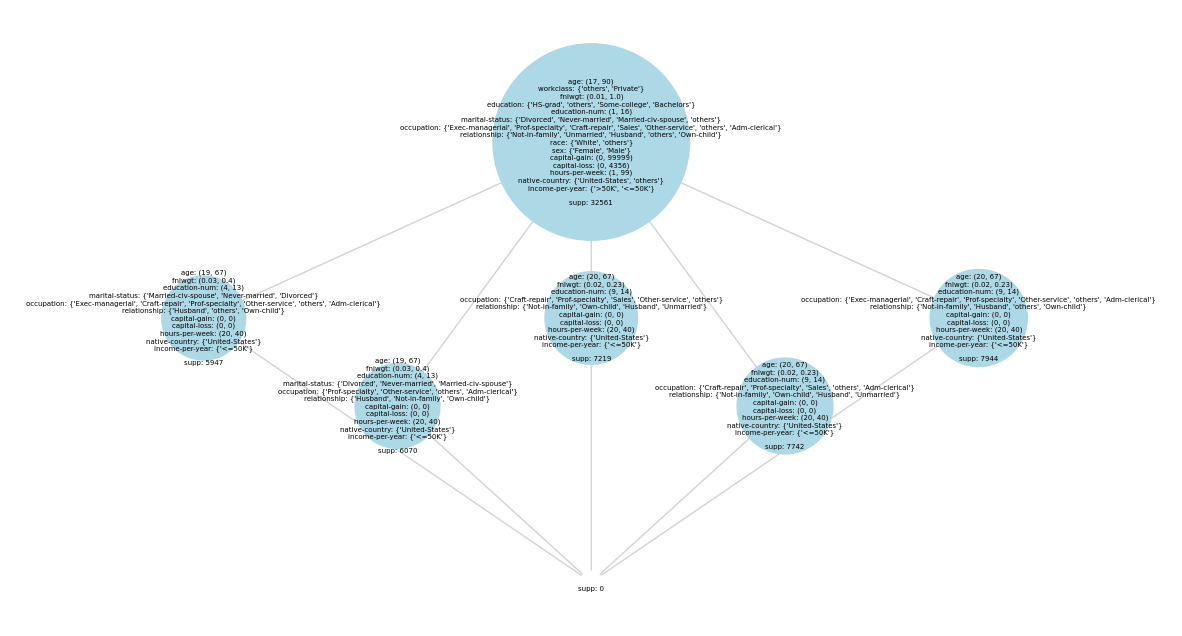

In [36]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))

nx.draw_networkx_edges(graph, pos=pos, ax=ax, edge_color='lightgray', arrowstyle='-')
nx.draw_networkx_nodes(graph, pos=pos, ax=ax, alpha=1, node_size=node_sizes, node_color='lightblue')
nx.draw_networkx_labels(graph, pos=pos, ax=ax, labels=dict(enumerate(node_labels)), font_size=5)

ax.set_ylim(-0.6, 0.8)
ax.set_xlim(-1.5, 1.5)
plt.box(False)

plt.savefig('adult_lattice.pdf')
plt.show()

In [39]:
df['race'].value_counts()/len(df)

White                 0.854274
Black                 0.095943
Asian-Pac-Islander    0.031909
Amer-Indian-Eskimo    0.009551
Other                 0.008323
Name: race, dtype: float64